# Base Model - Floods
This notebook shows an implementation of the base model.

In [1]:
import pandas as pd

from prisk.asset import PowerAsset, Location
from prisk.flood import FloodExposure
from prisk.utils import convert_to_continous_damage

## Data description
Two types of data are needed for the base model:
1. **Exposure data**: needs to contain information on the flood depths for different return periods
2. **Damage curves**: information required to translate the flood depths to financial impacts

In [2]:
power = pd.read_excel("../Data/power.xlsx")
damage_curves = pd.read_excel("../Data/damage_curves.xlsx")
continuous_curves = convert_to_continous_damage(damage_curves)



## Single asset - Example
To show the model behavior, we first do an example for a single asset:

In [3]:
asset = power.iloc[0]

return_period_columns = [c for c in power.columns if isinstance(c, int)]
flood_exposure = [FloodExposure(return_period, asset[return_period]) 
                   for return_period in return_period_columns
]

power_asset = PowerAsset(
    name=asset["Plant / Project name"],
    status=asset["Status"],
    country=asset["Country"],
    location=Location(latitude=asset["Latitude"], longitude=asset["Longitude"]),
    value=asset["Value"],
    flood_exposure=flood_exposure,
    flood_damages=continuous_curves,
    capacity=asset["Capacity (MW)"],
    type=asset["Type"],
)

power_asset.plot_risk()
print("PRISK: {:.2f}".format(power_asset.prisk))
power_asset.flood_exposure

PRISK: 0.98


[FloodExposure(return_period=2, depth=0.0),
 FloodExposure(return_period=5, depth=0.0),
 FloodExposure(return_period=10, depth=0.0),
 FloodExposure(return_period=25, depth=0.0),
 FloodExposure(return_period=50, depth=0.23),
 FloodExposure(return_period=100, depth=4.55),
 FloodExposure(return_period=200, depth=9.37),
 FloodExposure(return_period=500, depth=16.08),
 FloodExposure(return_period=1000, depth=21.33)]

## All assets

In [4]:
prisks, capital_impact, disruption_impact = [], [], []
return_period_columns = [c for c in power.columns if isinstance(c, int)]

for _, asset in power.iterrows():
    flood_exposure = [FloodExposure(return_period, asset[return_period]) 
                    for return_period in return_period_columns
    ]

    power_asset = PowerAsset(
        name=asset["Plant / Project name"],
        status=asset["Status"],
        country=asset["Country"],
        location=Location(latitude=asset["Latitude"], longitude=asset["Longitude"]),
        value=asset["Value"],
        flood_exposure=flood_exposure,
        flood_damages=continuous_curves,
        capacity=asset["Capacity (MW)"],
        type=asset["Type"],
    )

    prisks.append(power_asset.prisk)
    capital_impact.append(power_asset.replacement_impact / power_asset.value)
    disruption_impact.append(power_asset.disruption_impact / power_asset.value)
power.loc[:, "prisk"] = prisks
power.loc[:, "capital_impact"] = capital_impact
power.loc[:, "disruption_impact"] = disruption_impact

<Axes: >

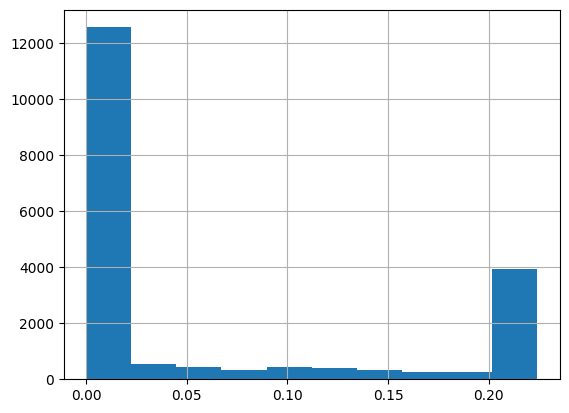

In [5]:
power.capital_impact.hist(bins=10)